# Imports / Set up

In [10]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Aliasing Overview

TODO: recreate fig 1 in paper to use darcy_pdebench data (and the standard training set up)

# HP Search

Find optimial HP config for darcy, burgers, and incompressible navier stokes

/tmp/ipykernel_2027529/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


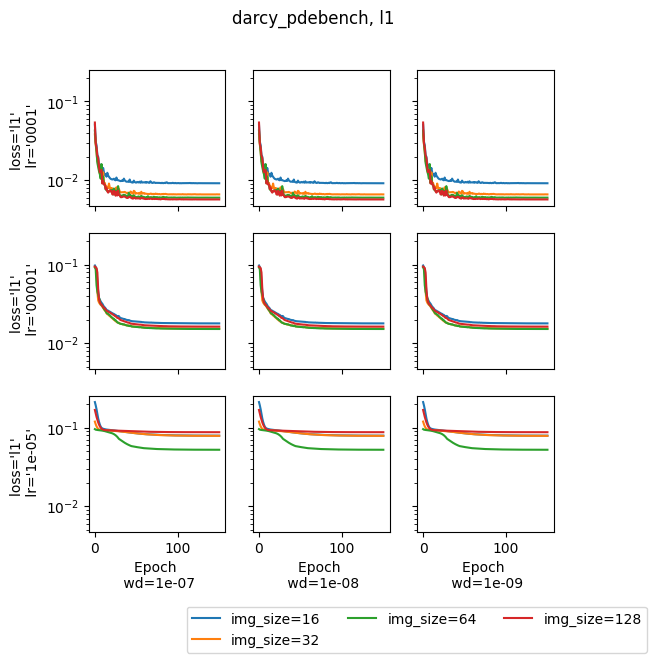

/tmp/ipykernel_2027529/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


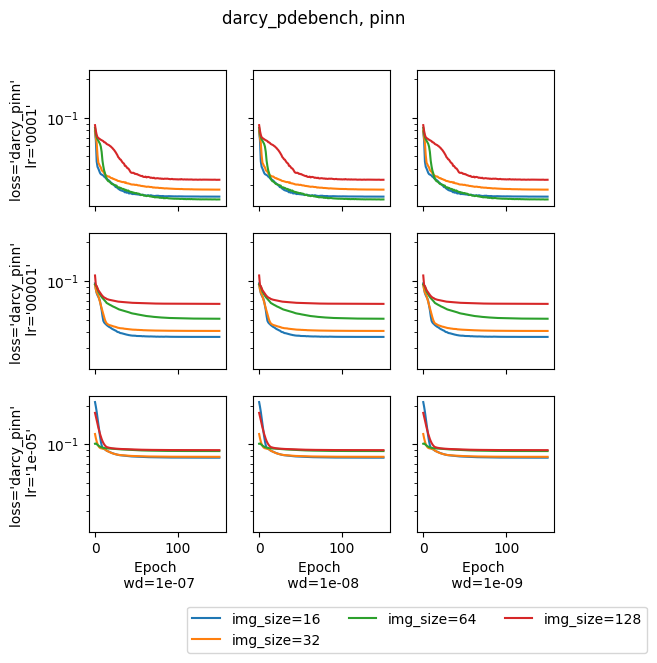

/tmp/ipykernel_2027529/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


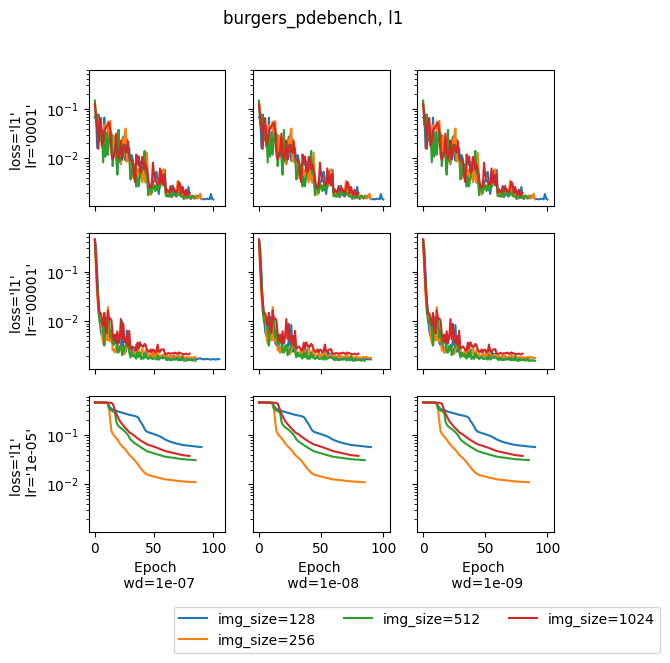

does not exist:  0001_1e-08_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10
does not exist:  0001_1e-09_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10
does not exist:  00001_1e-07_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10
does not exist:  00001_1e-08_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10
does not exist:  00001_1e-09_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10
does not exist:  1e-05_1e-07_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10
does not exist:  1e-05_1e-08_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10
does not exist:  1e-05_1e-09_15_05_burgers_pinn_64_burgers_pdebench_-1_-1_1024_512_FNO1D_10_10


/tmp/ipykernel_2027529/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


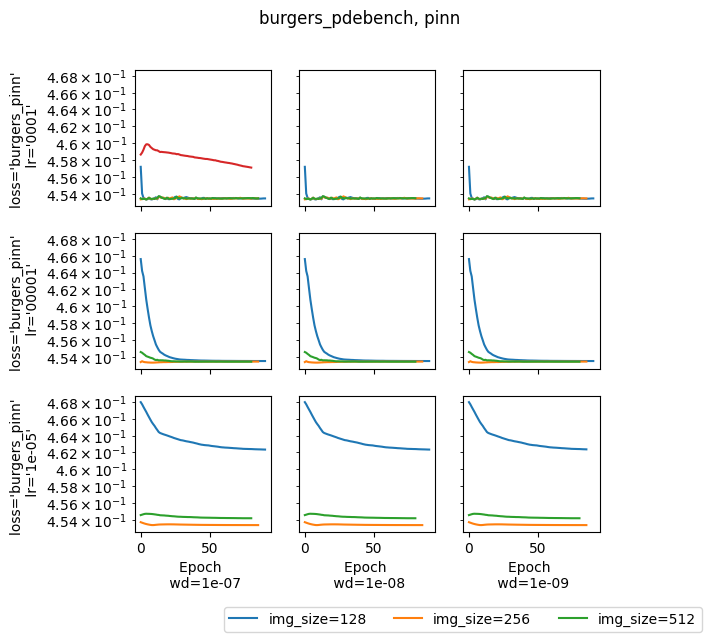

does not exist:  0001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_85_42_FNO2D_10_10
does not exist:  0001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_255_127_FNO2D_10_10
does not exist:  0001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_85_42_FNO2D_10_10
does not exist:  0001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_255_127_FNO2D_10_10
does not exist:  0001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_85_42_FNO2D_10_10
does not exist:  0001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_255_127_FNO2D_10_10
does not exist:  0001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_85_42_FNO2D_10_10
does not exist:  00001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_255_127_FNO2D_10_10
does not exist:  00001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_

/tmp/ipykernel_2027529/8617956.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0, -0.5), loc='upper center', ncols=3)


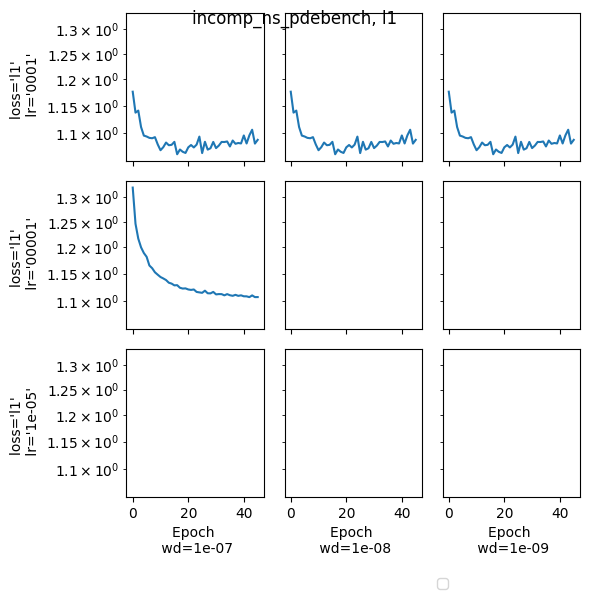

does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_17_8_FNO2D_10_10
does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_85_42_FNO2D_10_10
does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_255_127_FNO2D_10_10
does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_17_8_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_85_42_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_255_127_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_17_8_FNO2D_10_10
does not exist:  0001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_85_42_FNO2D_10_10
does not exist:  0001_1e-09_15_05_incomp_ns_pinn_4_inco

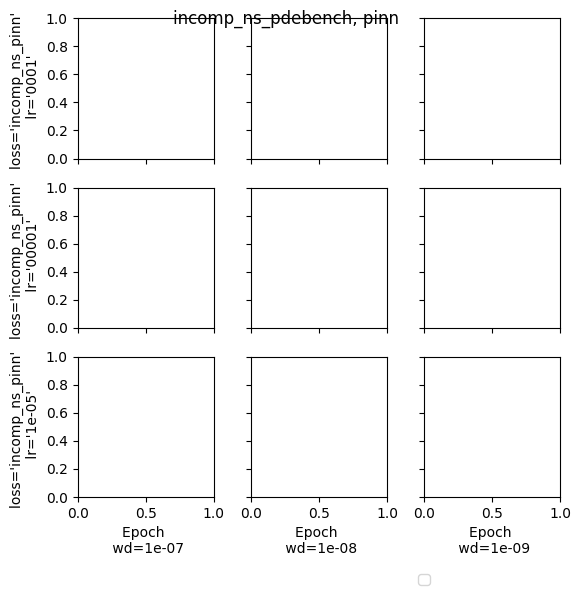

finished_exp=72, total_exp=216, 0.3333333333333333 %


In [20]:
# Check if all experiments have finished
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'

total_exp = 0
finished_exp = 0
for dataset_name in ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench']:
    model_name = 'FNO2D'
    in_channels = 10
    initial_steps = 10

    if dataset_name == 'darcy_pdebench':
        img_sizes = [16, 32, 64, 128]
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        pinn_loss_name = 'incomp_ns_pinn'
        batch_size = 4
            
    for loss_type in ['l1', 'pinn']:
        loss = "l1"
        if loss_type == "pinn":
            loss = pinn_loss_name
        fig, axes = plt.subplots(
            nrows=3, ncols=3, sharey=True, sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-07, 1e-08, 1e-09]):
                for color_idx, img_size in enumerate(img_sizes):
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print("does not exist: ", ckpt_dir)
                        continue
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                        sns.lineplot(
                            df, x='epoch', y=ylabel, label=f"{img_size=}", ax=axes[y_idx, x_idx]
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')
                     
                if y_idx == 2:
                    axes[y_idx, x_idx].set_xlabel(
                        f'Epoch \n {wd=}'
                    )
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss=} \n {lr=}')
                
        plt.legend(bbox_to_anchor=(0, -0.5), loc='upper center', ncols=3)
        plt.tight_layout()
        fig.suptitle(f"{dataset_name}, {loss_type}")
        plt.show()
print(f"{finished_exp=}, {total_exp=}, {finished_exp/total_exp} %")